In [1]:
!pip install -q kaggle

In [2]:
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import numpy as np
import shutil
import pickle
import random
from PIL import Image
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!mkdir /content/dataset

!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

!unzip -q '/content/microsoft-catsvsdogs-dataset' -d '/content/dataset'

print('Dataset downloaded and unzipped.')

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 99% 781M/788M [00:09<00:00, 125MB/s]
100% 788M/788M [00:09<00:00, 86.0MB/s]
Dataset downloaded and unzipped.


In [4]:
cat_images_path = '/content/dataset/PetImages/Cat'
dog_images_path = '/content/dataset/PetImages/Dog'
mixed_images_path = '/content/dataset/mixed'

In [5]:
os.makedirs(mixed_images_path, exist_ok=True)

# Function to move random images
def move_random_images(src, dest, num_images):
    image_files = [img_name for img_name in os.listdir(src) if img_name.endswith(('.png', '.jpg', '.jpeg'))]
    random_images = random.sample(image_files, min(num_images, len(image_files)))  # Select 20 random images
    for img_name in random_images:
        shutil.copy(os.path.join(src, img_name), dest)

move_random_images(cat_images_path, mixed_images_path, num_images=200)
move_random_images(dog_images_path, mixed_images_path, num_images=200)

print("200 images from both 'Cat' and 'Dog' folders have been combined into the 'mixed' folder.")

200 images from both 'Cat' and 'Dog' folders have been combined into the 'mixed' folder.


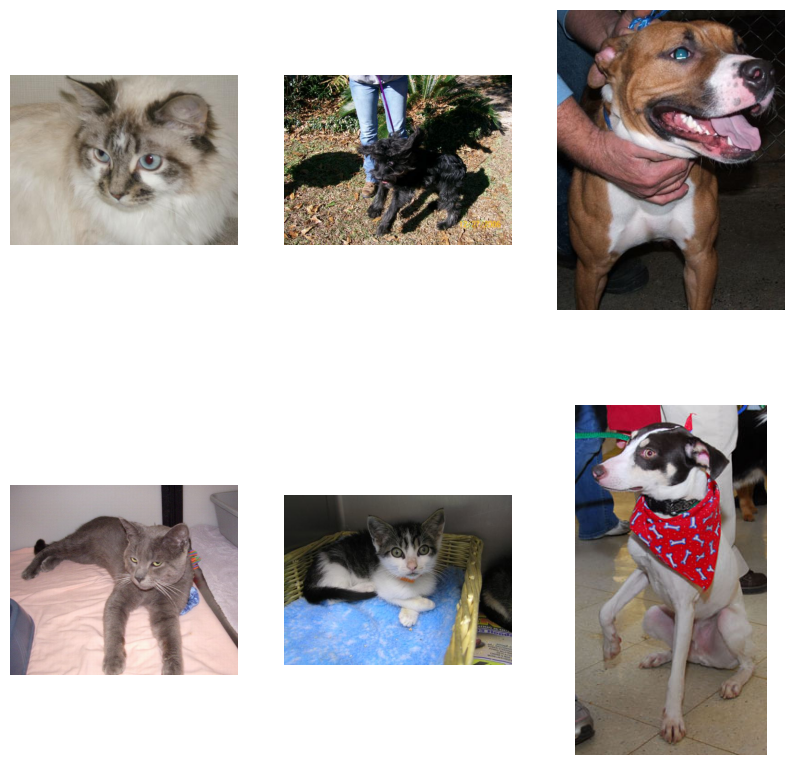

In [6]:
def display_random_images(folder_path, num_images):
    image_files = [img_name for img_name in os.listdir(folder_path) if img_name.endswith(('.png', '.jpg', '.jpeg'))]
    random_images = random.sample(image_files, min(num_images, len(image_files)))  # Select random images to display

    plt.figure(figsize=(10, 10))

    for i, img_name in enumerate(random_images, 1):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)

        # Display each image in a subplot
        plt.subplot(2, 3, i)
        plt.imshow(img)
        plt.axis('off')

display_random_images(mixed_images_path, num_images=6)

In [7]:
# Define the target size
target_size = (256, 256)

# Check and resize images in the mixed folder
for img_name in os.listdir(mixed_images_path):
    if img_name.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(mixed_images_path, img_name)

        # Read the image using cv2
        img = cv2.imread(img_path)

        # Check if the image was loaded correctly
        if img is not None:
            # Resize the image if the size does not match
            if img.shape[1] != target_size[0] or img.shape[0] != target_size[1]:  # width, height
                img = cv2.resize(img, target_size)
                cv2.imwrite(img_path, img)  # Save the resized image
        else:
            # Remove the corrupted image
            os.remove(img_path)
            print(f"Removed corrupted image: {img_path}")

print("All images resized to 256x256 if necessary. Corrupted images have been removed.")

Removed corrupted image: /content/dataset/mixed/4367.jpg
All images resized to 256x256 if necessary. Corrupted images have been removed.


## Model

In [8]:
os.chdir(mixed_images_path)

images = []

In [9]:
for file in os.listdir(mixed_images_path):
    if file.endswith(('.jpg', '.png', 'jpeg')):
        images.append(file)

In [10]:
model = EfficientNetB2(weights='imagenet', include_top=False, pooling='avg')

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
def feature_extractor(file, model):
    image = tf.keras.preprocessing.image.load_img(file)
    image = tf.keras.preprocessing.image.img_to_array(image)
    reshaped_image = np.expand_dims(image, axis=0) # Add a batch dimension

    image_processed =  tf.keras.applications.efficientnet_v2.preprocess_input(reshaped_image)
    features = model.predict(image_processed, batch_size=32)

    return features.flatten()

In [12]:
data = {}
feature_vectors_path = '/content/feature_vectors.pkl'

In [17]:
image_count = 0
for filename in os.listdir(mixed_images_path):
  if filename.endswith(('.png', '.jpg', '.jpeg')):
    image_count += 1

print(f"There are {image_count} images in the folder.")

There are 397 images in the folder.


In [20]:
%%capture

random_images = random.sample(images, image_count)

for image in random_images:
    try:
        feat = feature_extractor(image, model)
        data[image] = feat
    except Exception as e:
        print(f'Error processing {image}: {e}')

print(f'Feature extraction for {image_count} random images succesful.')

In [21]:
with open(feature_vectors_path, 'wb') as file:
    pickle.dump(data, file)

In [22]:
filenames = np.array(list(data.keys()))
features = np.array(list(data.values()))

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(random_state=47)
pca.fit(features)

PCA(random_state=47)

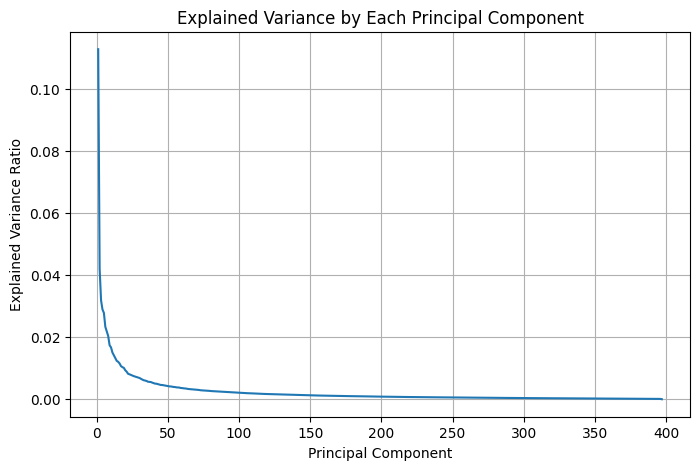

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

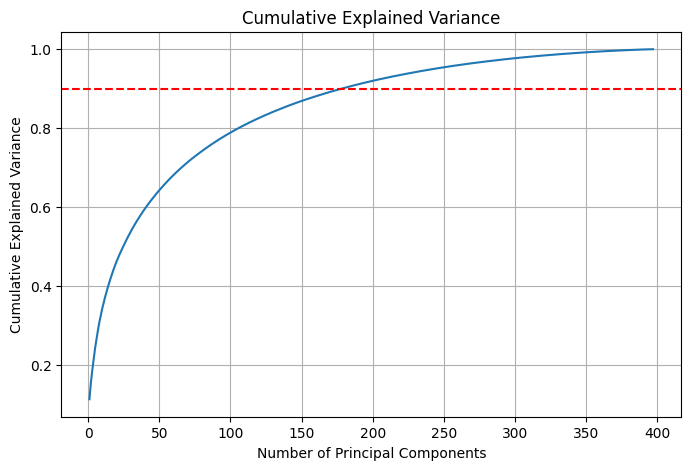

In [26]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% Variance Threshold
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

In [27]:
optimal_components = next(i for i, total_variance in enumerate(cumulative_variance, 1) if total_variance >= 0.90)
print(f"Optimal number of components to retain (90% explained variance): {optimal_components}")

Optimal number of components to retain (90% explained variance): 179


In [28]:
pca = PCA(n_components=optimal_components, random_state=42)
pca.fit(features)
x = pca.transform(features)

## Clustering

In [29]:
from sklearn.cluster import KMeans

In [30]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=47)
kmeans.fit(x)

KMeans(n_clusters=2, random_state=47)

In [31]:
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups:
        groups[cluster] = []
    groups[cluster].append(file)

In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [33]:
# Function to view a cluster (based on identifier)
def view_cluster(cluster, base_path):
    plt.figure(figsize=(25, 25))
    files = groups[cluster]

    files = files[:5]

    for index, file in enumerate(files):
        plt.subplot(6, 5, index + 1)

        img_path = os.path.join(base_path, file)
        img = load_img(img_path)

        # Convert image to array for display
        img = img_to_array(img)
        plt.imshow(img.astype('uint8'))

        plt.axis('off')

    plt.show()

Displaying images for Cluster 0:


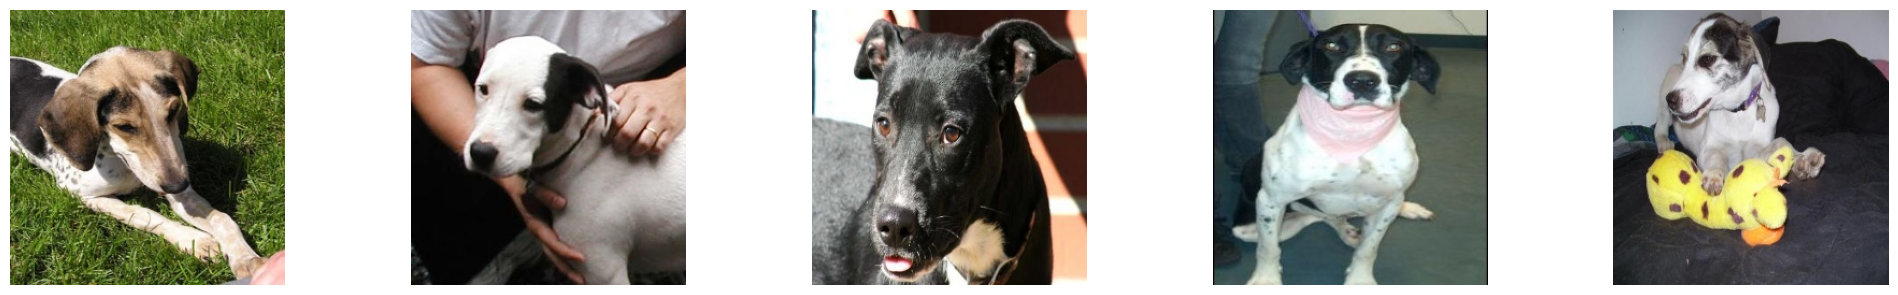

Displaying images for Cluster 1:


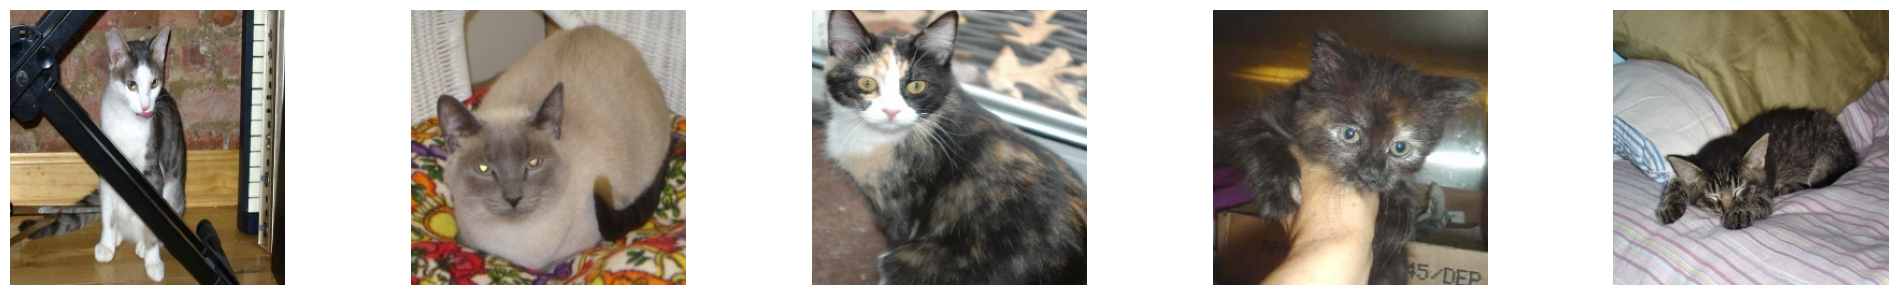

In [34]:
# Set the base path to your mixed dataset
base_path = '/content/dataset/mixed'

# Display images in Cluster 0
print("Displaying images for Cluster 0:")
view_cluster(0, base_path)

# Display images in Cluster 1
print("Displaying images for Cluster 1:")
view_cluster(1, base_path)


In [37]:
from mpl_toolkits.mplot3d import Axes3D

In [38]:
features = np.array(list(data.values()))

pca = PCA(n_components=2)  # For 2D projection
pca_result_2d = pca.fit_transform(features)

pca_3d = PCA(n_components=3)  # For 3D projection
pca_result_3d = pca_3d.fit_transform(features)

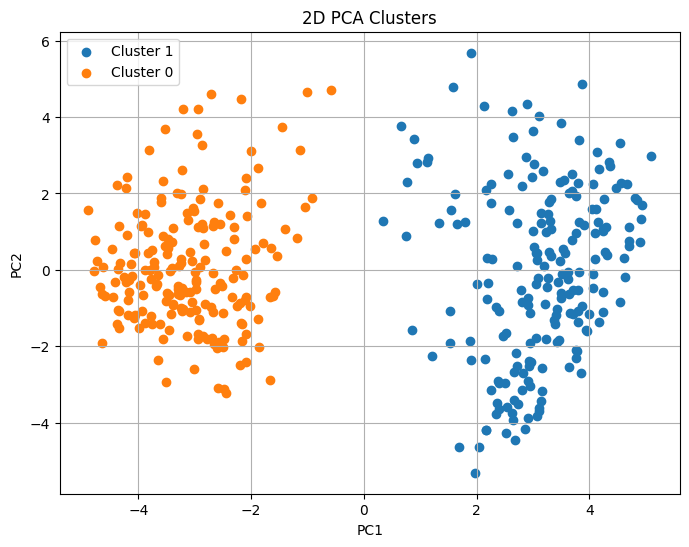

In [42]:
plt.figure(figsize=(8, 6))
for cluster, files in groups.items():
    indices = [list(data.keys()).index(file) for file in files]
    plt.scatter(pca_result_2d[indices, 0], pca_result_2d[indices, 1], label=f'Cluster {cluster}')
plt.legend()
plt.title('2D PCA Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

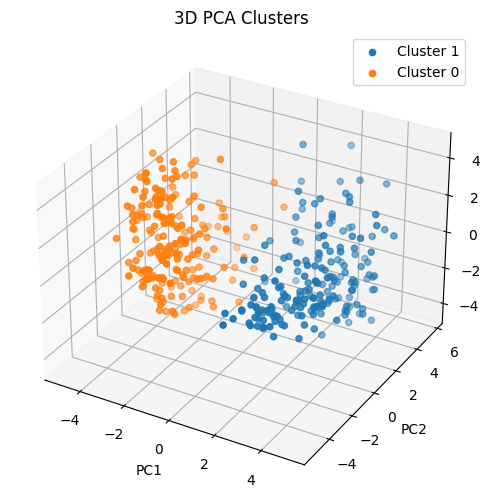

In [43]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for cluster, files in groups.items():
    indices = [list(data.keys()).index(file) for file in files]
    ax.scatter(pca_result_3d[indices, 0], pca_result_3d[indices, 1], pca_result_3d[indices, 2], label=f'Cluster {cluster}')
ax.set_title('3D PCA Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()

In [44]:
from sklearn.manifold import TSNE

In [45]:
tsne = TSNE(n_components=2, random_state=47)
tsne_result_2d = tsne.fit_transform(features)

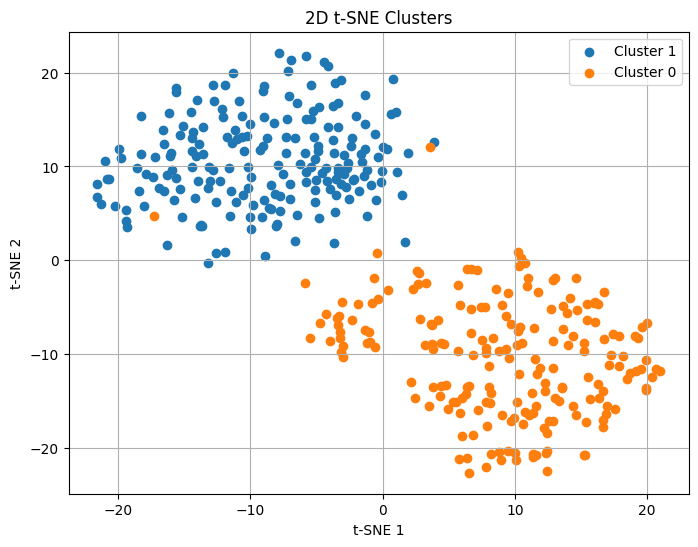

In [47]:
plt.figure(figsize=(8, 6))
for cluster, files in groups.items():
    indices = [list(data.keys()).index(file) for file in files]
    plt.scatter(tsne_result_2d[indices, 0], tsne_result_2d[indices, 1], label=f'Cluster {cluster}')
plt.legend()
plt.title('2D t-SNE Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()